# Training Notebook using Tensorflow and the New Data API
This notebook explores a model architecture ustilsing a Recurrent Neural Network with Gated Recurent Units.

A small subset of the training data is used to help ensure faster iterations.

# Feature Engineering
This section is responsible for taking audio wav formatted files and producing mel spectrograms for use in training and testing.

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow.contrib.signal as signal

def load_wav_file(audio_filename, sample_rate, channel_count=1):
    """ Return the audio wav file data in a Tensor.
    
    Args:
        audio_filename (str): File name including the full path
        sample_rate (int)   : The sample rate of the audio file
        channel_count (int) : The number of channels in the audio data (default is 1)
    
    Returns:
        Tensor: The wav file data of the first channel
    """
    audio_data = tf.read_file(audio_filename)
    raw_data = tf.contrib.ffmpeg.decode_audio(audio_data, file_format='WAV', samples_per_second=sample_rate, channel_count=channel_count)
    raw_data = raw_data[:,0]
    
    return raw_data

def compute_mel(audio_data, sample_rate=16000, keyword_duration=3.5, frame_duration=0.1, stride_duration=0.02 ):
    """ Return the log mel spectrogram of the provided audio data.
    
    Notes:
        To understand the resulting Tensor dimentions the following should help provide intuition.
        For a keyword that is 3.5 seconds in duration, an sFFT frame size of 0.1 seconds, and a sliding window step of 0.02 seconds
        you get the following:
        
        Total samples in 3.5 seconds sampled at 16kHz = 56,000
        Total unique overlapping windows of size 0.1 second with 0.02 second stride = (3.5 seconds - 0.1 seconds + 0.02 seconds) / 0.02 seconds = 171
        This function will produce a [171, 40] mel spectrogram for each 0.02 second stride.
        
    Args:
        audio_data (Tensor): the audio data for a single frame
        sample_rate (int)  : the sampling frequency of the audio data
        keyword_duration (float) : the time window to compute the log mel spectrogram over
        frame_duration (float) : the time window of an audio frame used to compute sfft
        stride_duration (float): the sliding window increment to provide window overlap for audio analysis
        
    Returns:
        Tensor: the log mel spectrogram computed from the audio data
    """
    
    # The default signal processing parameters are defaulted for keyword spotting applications.
    fft_length = 512
    num_mel_bins = 40
    lower_edge_hertz = 80
    upper_edge_hertz = 7600
    
    target_frame_length = sample_rate * keyword_duration
    frame_length = sample_rate * frame_duration
    frame_step = sample_rate * stride_duration
       
    # Compute a [batch_size, ?, frame_length] tensor of fixed length, overlapping windows
    # where each window overlaps the previous (frame_length - frame_step samples of overlap).

    frames = signal.frame(audio_data, frame_length=int(target_frame_length), frame_step=int(frame_length))
    windowed_frames = frames * signal.hamming_window(window_length=int(target_frame_length), periodic=True)

    # `magnitude_spectrograms` is a [batch_size, ?, frame_length] tensor of spectrograms. We
    # would like to produce overlapping fixed-size spectrogram patches; for example,
    # for use in a situation where a fixed size input is needed.
    magnitude_spectrograms = tf.abs(signal.stft(windowed_frames, frame_length=int(frame_length), frame_step=int(frame_step), fft_length=fft_length))

    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

    linear_to_mel_weight_matrix = signal.linear_to_mel_weight_matrix(
        num_mel_bins, 
        num_spectrogram_bins, 
        sample_rate, 
        lower_edge_hertz, 
        upper_edge_hertz
    )
    mel_spectrograms = tf.tensordot(
        magnitude_spectrograms, 
        linear_to_mel_weight_matrix, 
        1
    )

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.log(mel_spectrograms + 1e-6)
    
    return log_mel_spectrograms

def compute_data_and_label(wav_filename, label_filename, sample_rate):
    """ Return the tuple of data and label.
    
    Args:
        filename ([str,str]): the data and label filenames
        
    Returns:
        tuple: features and labels.
    """
    print(wav_filename, label_filename)
    wav_data = load_wav_file(wav_filename, sample_rate)
    features = compute_mel(wav_data)
    labels = np.load(label_filename).astype(int)
    return features, labels

# Helper Functions
def normalize(train):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    print("mean: %f"%mean)
    print("std: %f"%std)
    return train, mean, std

def normalize_with_paras(test, mean, std):
    test = (test - mean) / std
    return test

def makedirs(path):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True) 

/Volumes/ThorsHammer/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# Data API input_fn
To use this input_fn with an Estimator you must wrap it in a lambda function and provide the required params.

In [2]:
def audio_dataset_input_fn(X, y, batch_size, num_epochs):
    """ Return the features and associated labels for a batch of audio frames.
    
    The input data files must be a wav format audio file with associated labels 
    stored in a numpy array structured file.
    
    This method requires the input data files and label files exist in the same directory
    and have the same naming convention. The number of rows in the data and label files must be the same.
    
    For example if the data file is called 1234-001.wav then the label file must be 
    called 1234-001-mel-labels.npy
    
    * Note * Estimators require a no-args input function.
    To use this input function in an Estimator you need to wrap it in a lambda function.
    
    For example:
    
        input_fn=lambda:dataset_input_fn(batch_size, num_epochs)
    
    Args:
        X (ndarray)       : the complete training data in a multi-dimentional array
        y (ndarray)       : the complete training labels in a 1-D array
        batch_size (int): the number of examples to return each call
        num_epochs (int): the number of training repeats for this dataset
        
    Returns:
        Tuple: an array of length batch_size or less containing features and associated labels
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    return next_element

# Load training data
Load the audio wav file data and label files and prepare them for use in training.

In [10]:
%%time
base_dir = '/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms'
training_file_prefixes = ['161225-000','161225-002','161225-006']
training_filenames = [(os.path.join(base_dir, x + '.wav'),os.path.join(base_dir, x + '-mel-labels.npy')) for x in training_file_prefixes]
test_file_prefixes = ['161225-001']
test_filenames = [(os.path.join(base_dir, x + '.wav'),os.path.join(base_dir, x + '-mel-labels.npy')) for x in test_file_prefixes]
check_file_prefixes = ['161225-003']
check_filenames = [(os.path.join(base_dir, x + '.wav'),os.path.join(base_dir, x + '-mel-labels.npy')) for x in check_file_prefixes]

sess = tf.InteractiveSession()

all_training_features = []
all_training_labels = []
all_test_features = []
all_test_labels = []
all_check_features = []
all_check_labels = []

# training data
for wav_filename, label_filename in training_filenames:
    features, labels = compute_data_and_label(wav_filename,label_filename, sample_rate=16000)
    all_training_features.append(features.eval())
    all_training_labels.append(labels)
    
# test data
for wav_filename, label_filename in test_filenames:
    features, labels = compute_data_and_label(wav_filename,label_filename, sample_rate=16000)
    all_test_features.append(features.eval())
    all_test_labels.append(labels)

# check data
for wav_filename, label_filename in check_filenames:
    features, labels = compute_data_and_label(wav_filename,label_filename, sample_rate=16000)
    all_check_features.append(features.eval())
    all_check_labels.append(labels)

sess.close()

X_train = np.vstack(all_training_features)
y_train = np.concatenate(all_training_labels).astype('int32')
print('Training features:',X_train.shape)
print('Training labels:',y_train.shape)

X_test = np.vstack(all_test_features)
y_test = np.concatenate(all_test_labels).astype('int32')
print('Test features:',X_test.shape)
print('Test labels:',y_test.shape)

X_check = np.vstack(all_check_features)
y_check = np.concatenate(all_check_labels).astype('int32')
print('Test features:',X_check.shape)
print('Test labels:',y_check.shape)

X_train, mean, std = normalize(X_train)
X_test = normalize_with_paras(X_test, mean, std)
X_check = normalize_with_paras(X_check, mean, std)

/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-000.wav /Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-000-mel-labels.npy
/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-002.wav /Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-002-mel-labels.npy
/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-006.wav /Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-006-mel-labels.npy
/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-001.wav /Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-001-mel-labels.npy
/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-003.wav /Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/161225-003-mel-labels.npy
Training features: (5933, 171, 40)
Training labels: (5933,)
Test features: (6059, 171, 40)
Test

# Model Definition

In [11]:
# def model_fn():
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import GRUCell
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir_train = "{}/run-{}-train/".format(root_logdir, now)
logdir_test = "{}/run-{}-test/".format(root_logdir, now)

tf.reset_default_graph()

n_inputs = 40
n_steps = 171

n_neurons = 40
n_layers = 2
n_fully_connected = 96
n_outputs = 2

learning_rate = 0.001

epsilon = 0.00000001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # n_steps is the number of time steps
y = tf.placeholder(tf.int64, [None])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# RNN(GRU) & fully connected layers
with tf.name_scope('rnn'):
    with tf.contrib.framework.arg_scope(
        [ fully_connected],
        weights_initializer = tf.contrib.layers.variance_scaling_initializer()):

        cells=[]
        for _ in range(n_layers):
            cell = tf.contrib.rnn.DropoutWrapper(GRUCell(num_units=n_neurons), input_keep_prob=keep_prob)
            cells.append(cell)
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=False)        
        outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
        FC_1_logits = fully_connected(states, n_fully_connected)
        logits = fully_connected(FC_1_logits, n_outputs, activation_fn=None)

# cost function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)

# Gradient decent optimiser
with tf.name_scope('train'):    
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimiser.minimize(loss)

# evaluation using accuracy
with tf.name_scope('eval'):
    proba = tf.nn.softmax(logits, name='proba')
    predicted = tf.argmax(proba,1)
    confusion = tf.confusion_matrix(labels=y, predictions=predicted)

    actual = y

    tp = tf.to_float(tf.count_nonzero(predicted * actual))
    tn = tf.to_float(tf.count_nonzero((predicted - 1) * (actual - 1)))
    fp = tf.to_float(tf.count_nonzero(predicted * (actual - 1)))
    fn = tf.to_float(tf.count_nonzero((predicted - 1) * actual))

    precision = tp /(tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)

    precision_summary = tf.summary.scalar('precision',precision)
    recall_summary = tf.summary.scalar('recall',recall)
    f1_summary = tf.summary.scalar('f1',f1)

    tp_summary = tf.summary.scalar('tp',tp)
    fp_summary = tf.summary.scalar('fp',fp)

    tn_summary = tf.summary.scalar('tn',tn)
    fn_summary = tf.summary.scalar('fn',fn)

    # Merge all the summaries and write them out
    merged = tf.summary.merge_all()
    file_writer_train = tf.summary.FileWriter(logdir_train, tf.get_default_graph()) 
    file_writer_test = tf.summary.FileWriter(logdir_test, tf.get_default_graph())

# return training_op

In [12]:
# Baseline accuracy i.e. always choose the most frequent class
baseline_acc = 100-(100.0*np.sum(y_test)/y_test.shape[0])
print('Baseline accuracy: %0.2f. This is achieved by choosing the majority class.'%baseline_acc)

Baseline accuracy: 99.83. This is achieved by choosing the majority class.


In [13]:
# for reproduceability
tf.set_random_seed(1436)

# training parameters
n_epochs = 100
batch_size = 96
best_model_file = ""
keep_prob_dropout = 0.5
training_size = X_train.shape[0]
print('training size:',training_size)

saver = tf.train.Saver()
run_dir = "kws-{}".format(n_epochs)

# main training logic
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    # build the data pipeline
    next_train_element = audio_dataset_input_fn(X_train, y_train,batch_size=batch_size,num_epochs=n_epochs)
   
    best_f1 = -1
    epoch = 0
    while epoch < n_epochs:
        example_count = 0
        while True:
            try:
                X_train_batch, y_train_batch = sess.run(next_train_element)
                example_count += X_train_batch.shape[0]
                sess.run(training_op, feed_dict={X: X_train_batch, y: y_train_batch, keep_prob:[keep_prob_dropout]})
                if example_count % training_size == 0:
                    epoch += 1
                    summary_train = sess.run(merged, {X: X_train, y: y_train, keep_prob:[keep_prob_dropout]})
                    file_writer_train.add_summary(summary_train,epoch)
                    file_writer_train.flush()

                    summary_test = sess.run(merged, {X: X_test, y: y_test, keep_prob:[1.0]})
                    file_writer_test.add_summary(summary_test,epoch)
                    file_writer_test.flush()   

                    # Compute epoch metrics of interest to print in this notebook 
                    pred_train = predicted.eval(feed_dict={X: X_train, y: y_train, keep_prob:[keep_prob_dropout]})
                    pred_test = predicted.eval(feed_dict={X: X_test, y: y_test, keep_prob:[1.0]})

                    logits_train_vals = logits.eval(feed_dict={X: X_train, y: y_train, keep_prob:[keep_prob_dropout]})
                    logits_test_vals = logits.eval(feed_dict={X: X_test, y: y_test, keep_prob:[1.0]})
                    confusion_train = confusion.eval(feed_dict={logits: logits_train_vals, y: y_train})
                    confusion_test = confusion.eval(feed_dict={logits: logits_test_vals, y: y_test})

                    tp_val_test = tp.eval(feed_dict={predicted:pred_test, actual:y_test})
                    tn_val_test = tn.eval(feed_dict={predicted:pred_test, actual:y_test})
                    fp_val_test = fp.eval(feed_dict={predicted:pred_test, actual:y_test})
                    fn_val_test = fn.eval(feed_dict={predicted:pred_test, actual:y_test})
                    prec_val_test = precision.eval(feed_dict={tp:tp_val_test,fp:fp_val_test})
                    rec_val_test = recall.eval(feed_dict={tp:tp_val_test,fn:fn_val_test})
                    f1_score_test = f1.eval(feed_dict={precision:prec_val_test, recall:rec_val_test})

                    print(epoch, "f1 test score:",f1_score_test)
                    # Save best model so far
                    model_dir = './saved test models/{}'.format(run_dir)
                    makedirs(model_dir)

                    if f1_score_test > 0 and f1_score_test >= best_f1:
                        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
                        fname = './{}/kws_model-{}-{}.ckpt'.format(model_dir,epoch,now)
                        best_model_file = '{}/kws_model-{}-{}.ckpt'.format(model_dir,epoch,now)
                        tf.add_to_collection("predicted", predicted)
                        tf.add_to_collection("X", X)
                        save_path = saver.save(sess, fname)
                        best_f1 = f1_score_test

                        print("Saved new best model with f1 score: %0.4f"%f1_score_test)
                        print("Train Confusion Matrix:")
                        print(confusion_train)
                        print("Test Confusion Matrix:")
                        print(confusion_test)
                        print('---')

            except tf.errors.OutOfRangeError:
                break
         
    file_writer_train.close()
    file_writer_test.close()

training size: 5933
1 f1 test score: 0.0
2 f1 test score: 0.0
3 f1 test score: 0.0
4 f1 test score: 0.0
5 f1 test score: 0.0
6 f1 test score: 0.0
7 f1 test score: 0.0
8 f1 test score: 0.0
9 f1 test score: 0.0
10 f1 test score: 0.0
11 f1 test score: 0.0
12 f1 test score: 0.0
13 f1 test score: 0.0
14 f1 test score: 0.0
15 f1 test score: 0.0
16 f1 test score: 0.0
17 f1 test score: 0.0
18 f1 test score: 0.0
19 f1 test score: 0.88888896
Saved new best model with f1 score: 0.8889
Train Confusion Matrix:
[[5885    8]
 [  17   23]]
Test Confusion Matrix:
[[6049    0]
 [   2    8]]
---
20 f1 test score: 0.7692308
21 f1 test score: 0.8333334
22 f1 test score: 0.8
23 f1 test score: 0.7407407
24 f1 test score: 0.7692308
25 f1 test score: 0.8333334
26 f1 test score: 0.8333334
27 f1 test score: 0.8333334
28 f1 test score: 0.8571428
29 f1 test score: 0.8695652
30 f1 test score: 0.8695652
31 f1 test score: 0.8695652
32 f1 test score: 0.9
Saved new best model with f1 score: 0.9000
Train Confusion Matri

# Generate a Prediction from a Saved Model
The model seems to have learned well.

In [14]:
print(best_model_file)

./saved test models/kws-100/kws_model-100-20180402045111.ckpt


In [ ]:
# best_model_file = r'./saved test models/kws-100/kws_model-100-20180402045111.ckpt'

In [15]:
# look at an example input
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf

mel_directory = r'/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5_100ms/'

# Learned Parameters from the training dataset
mean = -2.544259
std = 1.705931

# known positive class frame
i = 0
num = len(X_check)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, best_model_file) # r"./saved models/kws-20/kws_model-19-20170904083803.ckpt")
    pred = predicted.eval(feed_dict={X:X_check, keep_prob:1.0})
    print('prediction:',pred)
    print(sum(pred))


INFO:tensorflow:Restoring parameters from ./saved test models/kws-100/kws_model-100-20180402045111.ckpt
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

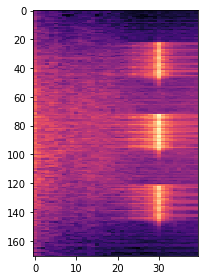

504 Label: 1


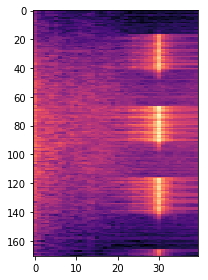

505 Label: 1


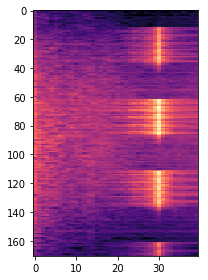

506 Label: 1


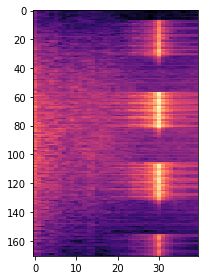

507 Label: 1


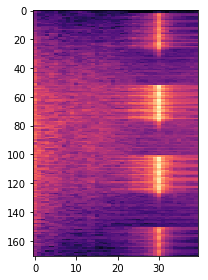

508 Label: 1


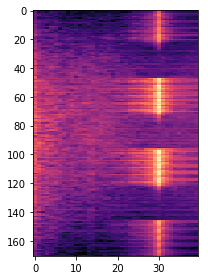

509 Label: 1


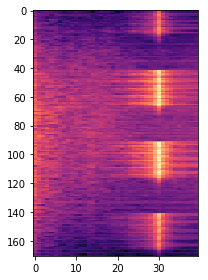

510 Label: 1


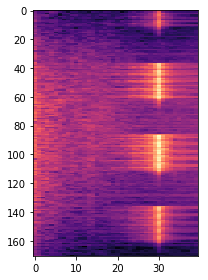

511 Label: 1


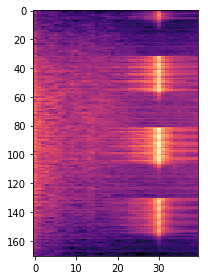

512 Label: 1


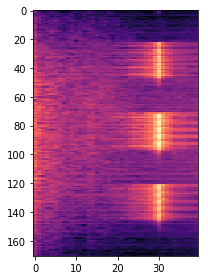

514 Label: 0


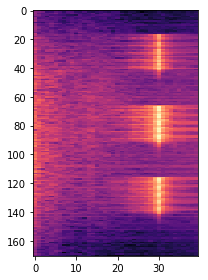

515 Label: 0


In [20]:
idx = np.where(pred > 0)[0]
for i in idx:
    fig, ax = plt.subplots(figsize=(3, 4))
    ax.imshow(X_check[i], cmap=plt.cm.magma, interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.show()
    print(i,'Label:',y_check[i])

# TODOs
* Hyper parameter tuning
* More test data
* Augment data with copies of beeps

In [21]:
np.where(pred == 1)

(array([504, 505, 506, 507, 508, 509, 510, 511, 512, 514, 515]),)

In [22]:
np.where(y_check == 1)

(array([503, 504, 505, 506, 507, 508, 509, 510, 511, 512]),)